In [1]:
!pip install pandas numpy matplotlib


In [2]:
from google.colab import files
uploaded = files.upload()

Saving application_record.csv to application_record.csv
Saving credit_record.csv to credit_record.csv


In [3]:
import pandas as pd
import sqlite3

In [4]:
# Load both CSVs
app_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")
print("Applications:", len(app_df), "| Credit records:", len(credit_df))

Applications: 438557 | Credit records: 1048575


In [5]:
# Clean column names
app_df.columns = [c.strip().replace(" ", "_").lower() for c in app_df.columns]
credit_df.columns = [c.strip().replace(" ", "_").lower() for c in credit_df.columns]

In [7]:
credit_df.columns

Index(['id', 'months_balance', 'status'], dtype='object')

In [8]:
# Drop duplicates
app_df = app_df.drop_duplicates(subset=["id"])
credit_df = credit_df.drop_duplicates(subset=["id", "months_balance"])

In [9]:
# Gender encoding
if "gender" in app_df.columns:
    app_df["gender"] = app_df["gender"].map({"M": 1, "F": 0})

In [11]:
# Create credit summary per customer
credit_summary = (
    credit_df.groupby("id")
    .agg(
        total_months=("months_balance", "count"),
        avg_status=("status", lambda x: pd.to_numeric(x, errors="coerce").mean(skipna=True)),
        late_payments=("status", lambda x: (x.isin(['1','2','3','4','5'])).sum())
    )
    .reset_index()
)

In [12]:
# Merge datasets
merged = pd.merge(app_df, credit_summary, on="id", how="left")

In [13]:
# Simple high-risk flag
merged["high_risk_flag"] = (
    (merged["late_payments"] > 3) |
    ((merged.get("income_total", 0) < 150000) & (merged["avg_status"] > 1))
).astype(int)

print("Merged dataset shape:", merged.shape)
merged.head()

Merged dataset shape: (438510, 22)


,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,total_months,avg_status,late_payments,high_risk_flag
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,16.0,0.5,1.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,15.0,0.5,1.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,30.0,0.0,0.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,5.0,0.0,0.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,5.0,NaN,0.0,0


In [19]:
total_customers = merged['id'].nunique()
high_risk = merged['high_risk_flag'].sum()
default_rate = round((high_risk / total_customers) * 100, 2)

avg_late = round(merged['late_payments'].mean(), 2)
avg_income_highrisk = round(merged.loc[merged['high_risk_flag'] == 1, 'amt_income_total'].mean(), 2)
corr_income_late = merged[['amt_income_total', 'late_payments']].corr().iloc[0,1]

print("📊 Credit Risk Metrics:")
print(f"Total customers: {total_customers}")
print(f"High-risk customers: {high_risk} ({default_rate}%)")
print(f"Average late payments: {avg_late}")
print(f"Average income (high-risk group): {avg_income_highrisk}")
print(f"Correlation (Income vs Late Payments): {corr_income_late:.3f}")


📊 Credit Risk Metrics:
Total customers: 438510
High-risk customers: 847 (0.19%)
Average late payments: 0.32
Average income (high-risk group): 193357.06
Correlation (Income vs Late Payments): 0.014


In [15]:
conn = sqlite3.connect(":memory:")
merged.to_sql("credit_merged", conn, index=False, if_exists="replace")

print("Total & High-Risk Counts:")
print(pd.read_sql_query("SELECT COUNT(*) AS total, SUM(high_risk_flag) AS high_risk FROM credit_merged;", conn))

print("\nAverage Income & Late Payments:")
print(pd.read_sql_query("SELECT AVG(amt_income_total) AS avg_income, AVG(late_payments) AS avg_late FROM credit_merged;", conn))

print("\nTop 5 Occupations by Applicants:")
print(pd.read_sql_query("SELECT occupation_type, COUNT(*) AS applicants FROM credit_merged GROUP BY occupation_type ORDER BY applicants DESC LIMIT 5;", conn))


Total & High-Risk Counts:
    total  high_risk
0  438510        847

Average Income & Late Payments:
      avg_income  avg_late
0  187525.415725  0.317497

Top 5 Occupations by Applicants:
  occupation_type  applicants
0            None      134193
1        Laborers       78231
2      Core staff       43000
3     Sales staff       41094
4        Managers       35481


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

X = merged[["amt_income_total", "late_payments", "avg_status", "total_months"]].fillna(0)
y = merged["high_risk_flag"].copy()


# Flip 5% of labels to simulate real-world imperfections
noise_ratio = 0.05
noise_idx = np.random.choice(y.index, size=int(noise_ratio * len(y)), replace=False)
y_noisy = y.copy()
y_noisy.loc[noise_idx] = 1 - y_noisy.loc[noise_idx]

print(f"Added noise to {len(noise_idx)} labels ({noise_ratio*100:.0f}% of data).")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_noisy, test_size=0.2, random_state=42, stratify=y_noisy
)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("\n📈 Logistic Regression (with 5% label noise)")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")


Added noise to 21925 labels (5% of data).

📈 Logistic Regression (with 5% label noise)
Accuracy : 0.950
Precision: 0.962
Recall   : 0.028
F1 Score : 0.054


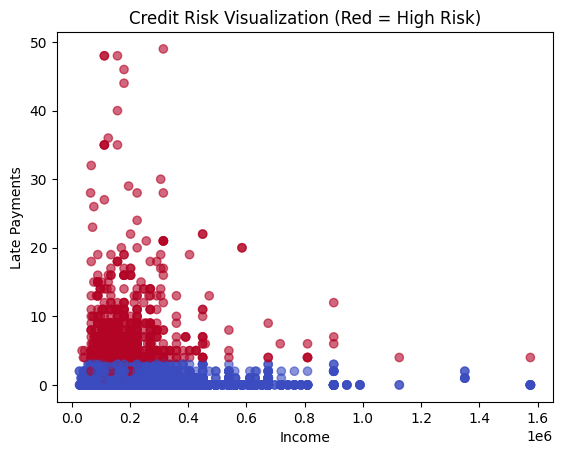

In [16]:
import matplotlib.pyplot as plt

plt.scatter(merged["amt_income_total"], merged["late_payments"],
            c=merged["high_risk_flag"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Income")
plt.ylabel("Late Payments")
plt.title("Credit Risk Visualization (Red = High Risk)")
plt.show()


In [23]:
merged.to_csv("credit_merged_processed.csv", index=False)
from google.colab import files
files.download("credit_merged_processed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>